In [1]:
%load_ext lab_black

In [2]:
from string import ascii_lowercase

import arviz as az
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15, 10)

In [3]:
rng = np.random.default_rng(seed=0)

In [4]:
β_0_mean = 1  # Simulation intercept
β_1_mean = 3  # Simulation slope
β_0_std = 0.25  # Noise for β_0
β_1_std = 0.125  # Noise for β_1

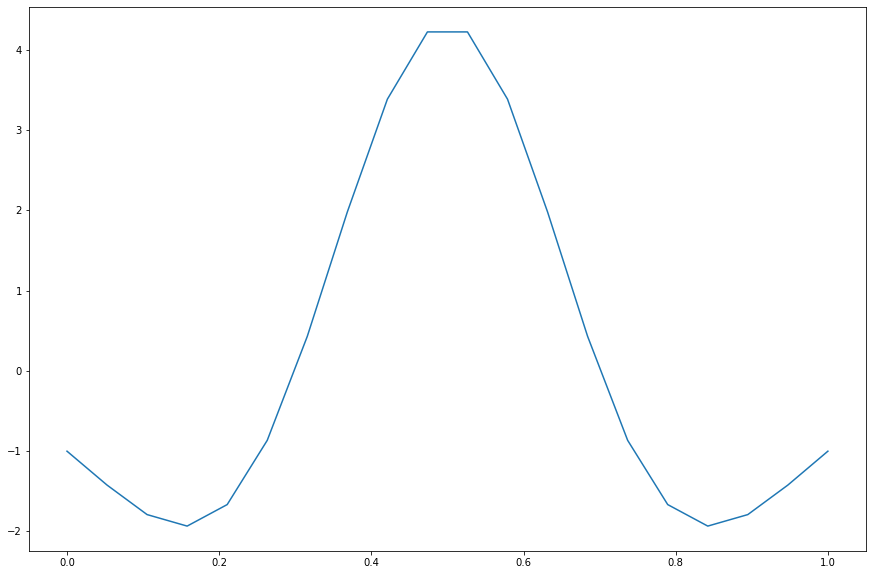

In [5]:
σ = 0.2
β_1_t = (
    lambda t: 2
    / ((σ * (3 ** 0.5)) * (np.pi ** 0.25))
    * (1 - ((t - 0.5) / σ) ** 2)
    * np.exp(-((t - 0.5) ** 2) / (2 * (σ) ** 2))
)  # Make some nonlinear function of time
# this is a Ricker wavelet https://en.wikipedia.org/wiki/Ricker_wavelet but has no specific relevance to the problem
t = np.linspace(0, 1, 20)
y = β_1_t(t)
plt.plot(t, y)

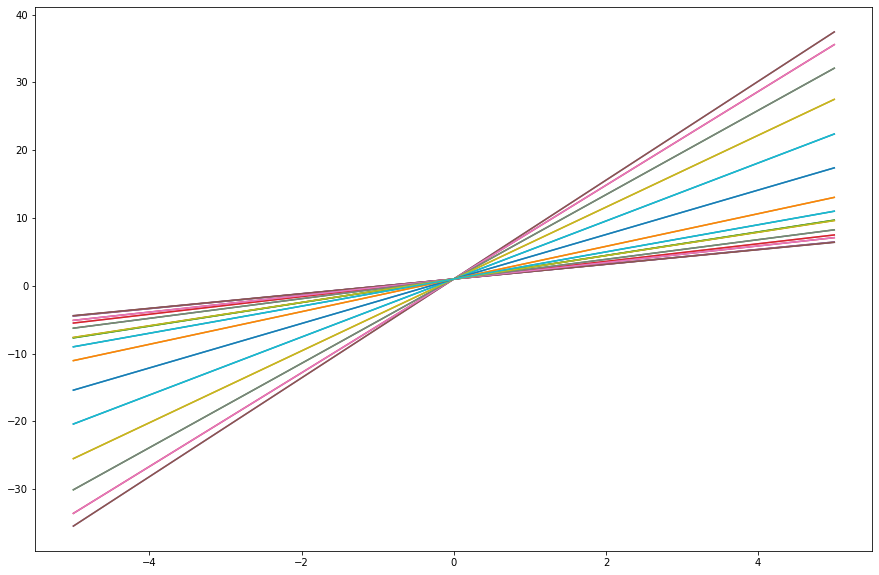

In [6]:
x = np.linspace(-5, 5, 40)
t = np.linspace(0, 1, 30)

perfect = np.array([β_0_mean + (β_1_mean + β_1_t(t_0)) * x for t_0 in t]).T
plt.plot(x, perfect)

In [7]:
# Create a table of the individual true projections
t = np.linspace(0, 1, len(ascii_lowercase))
truth_data = pd.DataFrame(
    [
        (
            c,
            i,
            t_c,
            β_0_mean + rng.normal() * β_0_std,
            β_1_mean + β_1_t(t_c) + rng.normal() * β_1_std,
        )
        for i, (c, t_c) in enumerate(zip(ascii_lowercase, t))
    ],
    columns=["item", "item_id", "init_time", "beta_0", "beta_1"],
)
truth_data

,item,item_id,init_time,beta_0,beta_1
0,a,0,0.00,1.031433,1.983162
1,b,1,0.04,1.160106,1.692120
2,c,2,0.08,0.866083,1.414826
3,d,3,0.12,1.326000,1.256766
4,e,4,0.16,0.824066,0.909595
5,f,5,0.20,0.844181,1.245296
6,g,6,0.24,0.418742,1.687299
7,h,7,0.28,0.688522,2.411161
8,i,8,0.32,0.863935,3.510024
9,j,9,0.36,1.102908,4.861405


In [8]:
feature_data = truth_data[["item", "item_id", "init_time"]]  # this is what I know

In [9]:
# make a table of the measurements
measurement_std = 0.35
x = np.linspace(0, 10, 20)

# I know this is bad but it is simple
item_col = []
measurements = []

for _, row in truth_data.iterrows():
    item_col += [row["item"]] * len(x)
    measurements += list(
        (row.beta_0 + row.beta_1 * x) + rng.normal(size=len(x)) * measurement_std
    )

measurement_table = pd.DataFrame(
    [(item, measurement) for item, measurement in zip(item_col, measurements)],
    columns=["item", "measurement"],
)
measurement_table = measurement_table.merge(
    feature_data, how="left", left_on="item", right_on="item",
)
measurement_table  # I have this as well

,item,measurement,item_id,init_time
0,a,1.029874,0,0.0
1,a,2.304968,0,0.0
2,a,2.668045,0,0.0
3,a,4.301034,0,0.0
4,a,5.356963,0,0.0
...,...,...,...,...
515,z,15.870579,25,1.0
516,z,17.030800,25,1.0
517,z,17.462990,25,1.0
518,z,18.872602,25,1.0


In [53]:
# Now for the model

with pm.Model() as model:
    intercept_sigma = pm.HalfNormal("intercept_sigma", 1)
    intercept_mean_dist = pm.Normal("intercept_mean_dist", mu=0, sigma=10)
    intercept_mean = pm.Normal(
        "intercept_mean", mu=intercept_mean_dist, sigma=intercept_sigma
    )

    #     intercept_noise = pm.Normal(
    #         "intercept_noise", mu=0, sigma=intercept_sigma, shape=len(feature_data)
    #     )

    slope_sigma = pm.HalfNormal("slope_sigma", 1)
    slope_mean_dist = pm.Normal("slope_mean_dist", mu=0, sigma=10)
    slope_mean = pm.Normal("slope_mean", mu=slope_mean_dist, sigma=slope_sigma)
    #     slope_noise = pm.Normal(
    #         "slope_noise", mu=0, sigma=slope_sigma, shape=len(feature_data)
    #     )

    slope_gp_η = pm.Exponential("slope_gp_η", 10)
    slope_gp_ρ = pm.Exponential("slope_gp_ρ", 10)
    slope_gp_cov = (slope_gp_η ** 2) * pm.gp.cov.ExpQuad(1, slope_gp_ρ)

    slope_gp = pm.gp.Latent(cov_func=slope_gp_cov)
    slope_gp_func = slope_gp.prior(
        "slope_gp", X=feature_data.init_time.values.reshape(-1, 1)
    )

    measurement_noise = pm.Exponential("measurement_noise", 1)

    combined = pm.Deterministic("combined", intercept_mean + slope_mean + slope_gp_func)
    #     combined_functions = pm.Deterministic(
    #         "combined",
    #         intercept_mean + intercept_noise + slope_mean + slope_noise + slope_gp_func,
    #     )
    mu = combined[measurement_table["item_id"].values]
    obs = pm.Normal(
        "observed",
        mu=mu,
        sigma=measurement_noise,
        observed=measurement_table.measurement.values,
    )

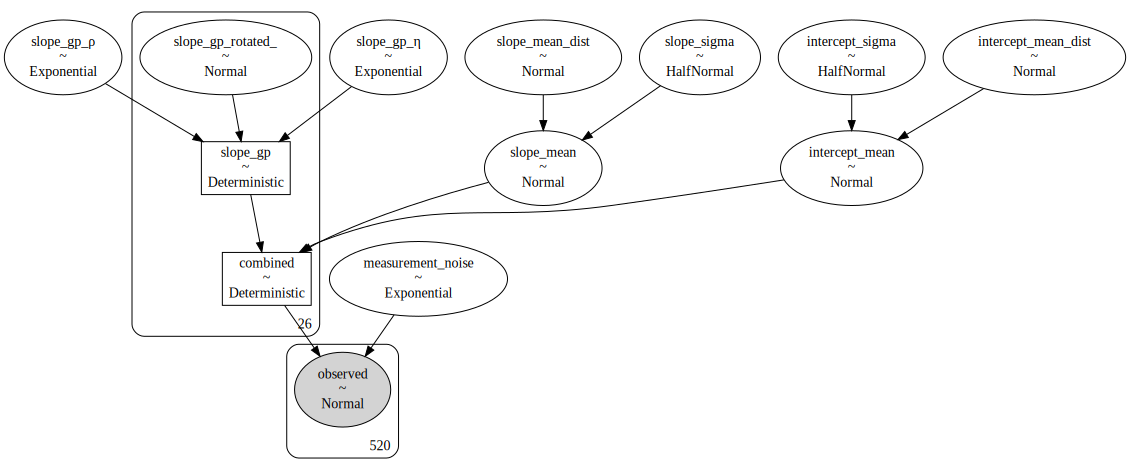

In [54]:
with model:
    display(pm.model_to_graphviz())

In [55]:
# run find_MAP to make sure things work
with model:
    est = pm.find_MAP()
est

{'intercept_sigma_log__': array(-18.24241206),
 'intercept_mean_dist': array(8.2972881),
 'intercept_mean': array(8.2972881),
 'slope_sigma_log__': array(-18.24241206),
 'slope_mean_dist': array(8.2972881),
 'slope_mean': array(8.2972881),
 'slope_gp_η_log__': array(-6.60666308),
 'slope_gp_ρ_log__': array(-6.81755422),
 'slope_gp_rotated_': array([ 0.46307613,  0.46073753,  0.48194956,  0.50872066,  0.51155129,
         0.46507054,  0.37901043,  0.23643921,  0.05760283, -0.11396663,
        -0.2429966 , -0.32615738, -0.34731393, -0.30426412, -0.20686196,
        -0.06667468,  0.08979538,  0.24096767,  0.35064813,  0.42539079,
         0.47350513,  0.47352034,  0.42007527,  0.33572906,  0.23242032,
         0.08838371]),
 'measurement_noise_log__': array(2.75788585),
 'intercept_sigma': array(1.1951464e-08),
 'slope_sigma': array(1.1951464e-08),
 'slope_gp_η': array(0.00135133),
 'slope_gp_ρ': array(0.00109439),
 'slope_gp': array([ 7.78478131e-04,  7.74546718e-04,  8.10206290e-04,  8.

In [56]:
with model:
    trace = pm.sample(
        tune=100000, draws=2000, target_accept=0.9, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [measurement_noise, slope_gp_rotated_, slope_gp_ρ, slope_gp_η, slope_mean, slope_mean_dist, slope_sigma, intercept_mean, intercept_mean_dist, intercept_sigma]


Sampling 4 chains for 100_000 tune and 2_000 draw iterations (400_000 + 8_000 draws total) took 12533 seconds.
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
There were 237 divergences after tuning. Increase `target_accept` or reparameterize.
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
There were 877 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.655555794466632, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [57]:
display(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_mean_dist,7.212,7.291,-4.707,22.495,0.692,0.491,110.0,2685.0,1.03
intercept_mean,7.294,7.317,-4.926,22.097,0.723,0.513,105.0,2481.0,1.03
slope_mean_dist,8.378,7.208,-5.738,21.255,0.396,0.281,483.0,2658.0,1.02
slope_mean,8.397,7.174,-5.944,20.977,0.306,0.216,723.0,2520.0,1.02
slope_gp_rotated_[0],-1.198,0.631,-2.435,-0.090,0.062,0.045,111.0,4316.0,1.03
...,...,...,...,...,...,...,...,...,...
combined[21],8.074,1.243,5.628,10.328,0.033,0.024,1362.0,1886.0,1.01
combined[22],8.231,1.241,5.870,10.562,0.031,0.022,1541.0,2157.0,1.01
combined[23],9.094,1.254,6.644,11.369,0.040,0.028,992.0,3063.0,1.01
combined[24],10.286,1.337,7.753,12.793,0.039,0.027,1148.0,3670.0,1.00


array([[<AxesSubplot:title={'center':'slope_gp_rotated_\n0'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n1'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n2'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n3'}>],
       [<AxesSubplot:title={'center':'slope_gp_rotated_\n4'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n5'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n6'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n7'}>],
       [<AxesSubplot:title={'center':'slope_gp_rotated_\n8'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n9'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n10'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n11'}>],
       [<AxesSubplot:title={'center':'slope_gp_rotated_\n12'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n13'}>,
        <AxesSubplot:title={'center':'slope_gp_rotated_\n14'}>,
        <AxesSubplot:title={'center':'slope_gp_

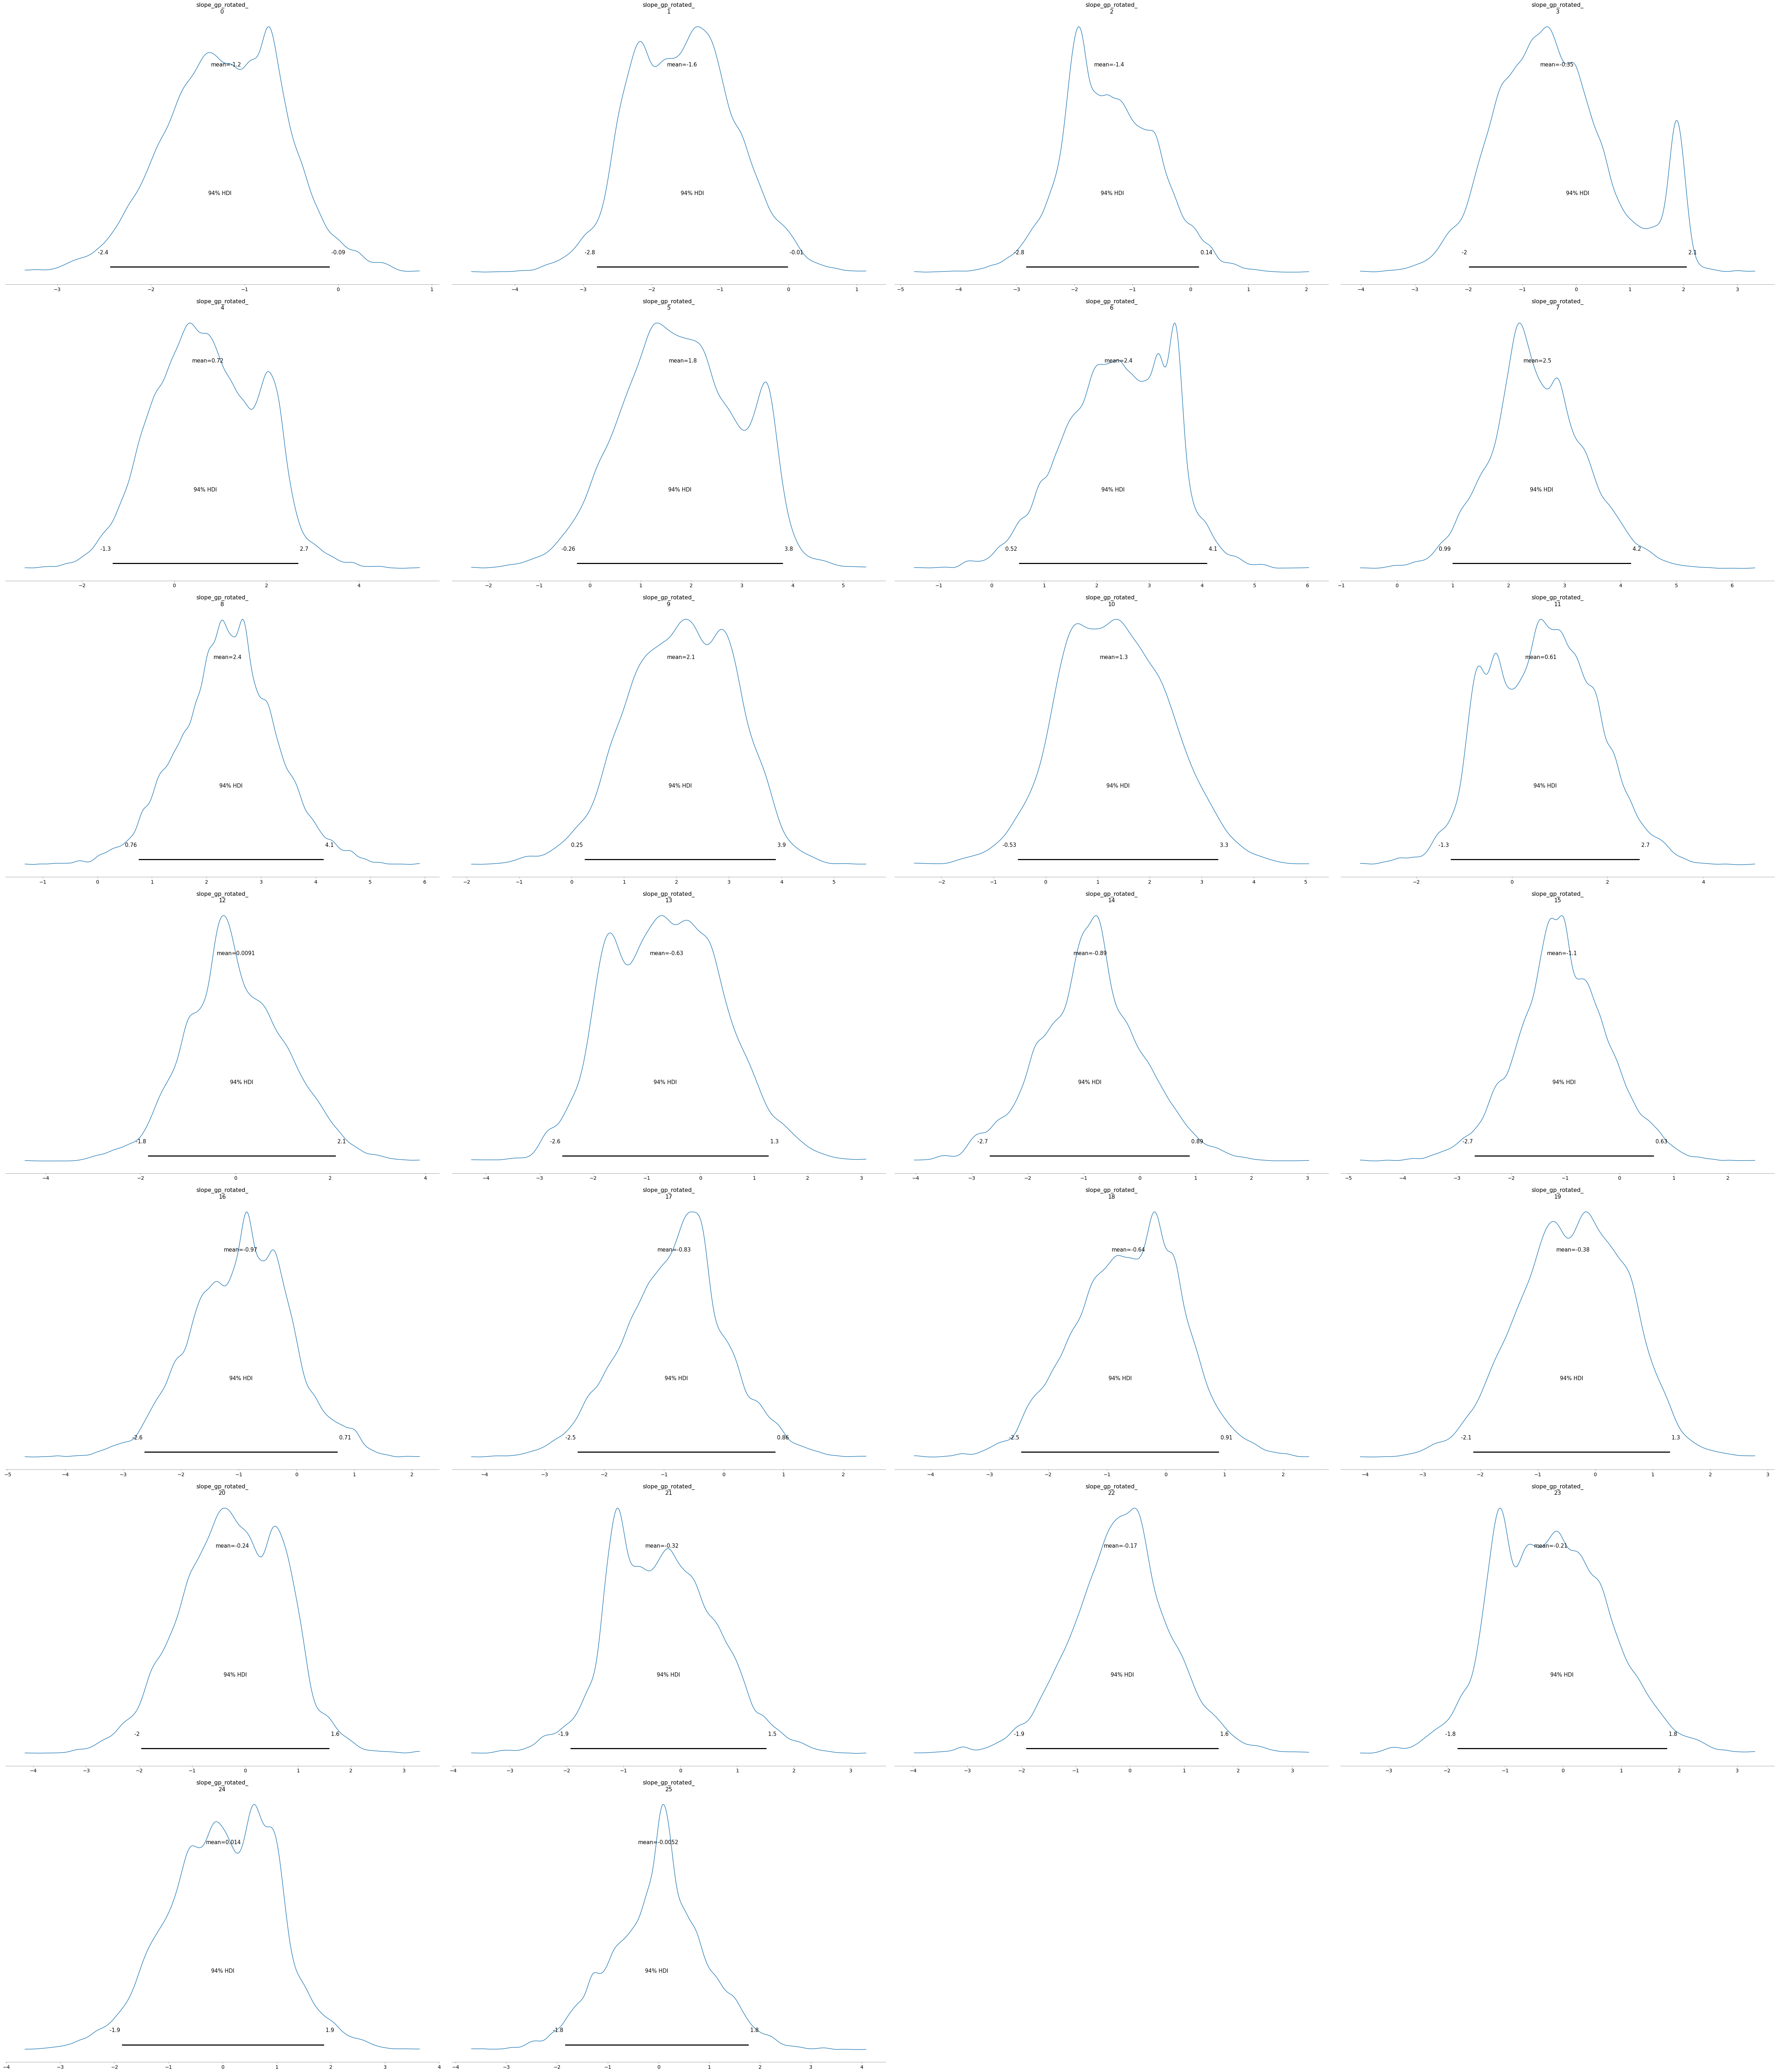

In [58]:
az.plot_posterior(trace, var_names=["slope_gp_rotated_"])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

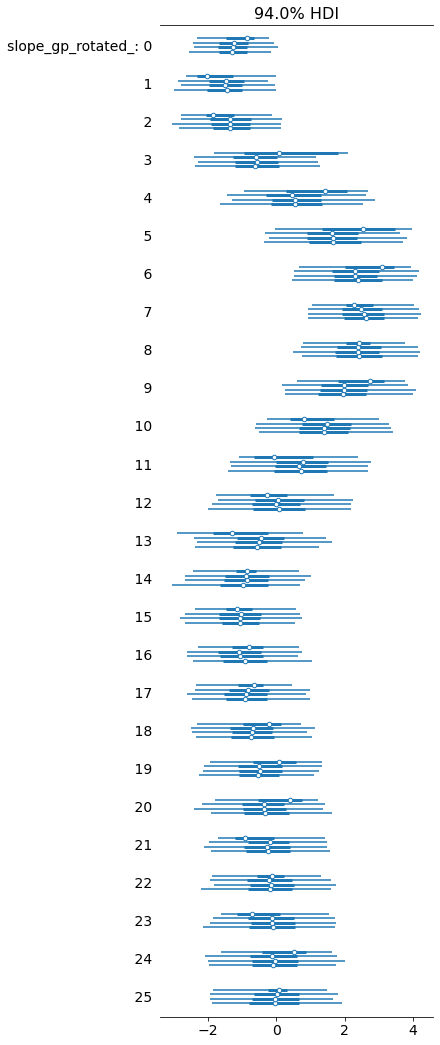

In [59]:
az.plot_forest(trace, var_names=["slope_gp_rotated_"])